# ASR Phonology Inference: Whisper v3 (French & Spanish)

This notebook quantifies which **phonology/prosody features** drive **WER** and how much of the **Cartesia transform** effect can be explained by those features.

**What it does** (for **French** and **Spanish** separately):
1. **Assemble datasets**:
   - *Line-paired deltas* (only lines present in both Original and Transformed)
   - *Speaker-paired deltas* (means per speaker, then difference)
   - *Pooled long set* (all observations with `treatment ∈ {0,1}`)
2. **Descriptives** and sanity checks.
3. **Δ‑Regression (primary inference)**: `Δ log1p(WER) ~ Σ βk ΔXk` with ridge CV → refit OLS for interpretable coefficients + clustered SEs (by speaker).
4. **Mixed‑effects confirmation** on the pooled set with random intercepts for speaker/country/gender and `treatment × features` interactions.
5. **Mediation**: estimate proportion of the transform’s effect explained via measured features (bootstrap CIs).
6. **Chi‑square tests**:
   - Improvement vs worsening counts (overall and by language)
   - Improvement vs feature‑change quartiles
7. **Robustness**: speaker‑paired deltas; winsorization/Huber; PCA variant.

> ⚠️ Assumptions:  
> • Your files are split into two top‑level folders: `original/` and `transformed/`, and further into `french/` and `spanish/`.  
> • Each CSV file corresponds to a `(country, gender)` combination and contains columns:  
> `speaker_id,line_id,rms_amplitude,dc_offset,articulation_rate,mean_pitch,pitch_std_dev,hnr,wer_score`.  
> • Filenames follow a pattern like: `belgium_female_*.csv` (country and gender recoverable via regex).  
> If your layout differs, edit the **Config** cell.


## Loading the Data

In [1]:
# === Config ===
from pathlib import Path
LANGUAGES = ["french", "spanish"]          # analyze separately
DATA_ROOT = Path("data")                    # change to your dataset root (relative to notebook)
ORIG_DIR = DATA_ROOT / "Acoustic Lines (with WER), Cleaned" # original
TRANS_DIR = DATA_ROOT / "Transformed Acoustic Lines (with WER), Cleaned" # transformed

# filename like "belgium_female_individual_sample_features.csv"
# adjust the regex if your names differ
FILENAME_RE = r"(?P<country>[a-z_]+)_(?P<gender>male|female).+\.csv"

FEATURES = ["rms_amplitude","dc_offset","articulation_rate","mean_pitch","pitch_std_dev","hnr"]
OUTCOME = "wer_score"
ID_COLS = ["speaker_id","line_id"]
GROUP_COLS = ["country","gender","language"]
TREATMENT_NAME = "treatment"               # 0=original, 1=transformed
RANDOM_SEED = 7

# ----- Tell the notebook which countries are FR vs ES -----
SPANISH_COUNTRIES = {
    "spain","argentina","chile","mexico","dominican_republic"
}
FRENCH_COUNTRIES = {
    "france","belgium","canada","senegal","ivory_coast"
}

def country_to_language(country: str) -> str:
    c = country.lower()
    if c in SPANISH_COUNTRIES: return "spanish"
    if c in FRENCH_COUNTRIES:  return "french"
    raise ValueError(f"Country not in mapping: {country}")

LANGUAGES = ["french","spanish"]     # analyzed separately

In [2]:
# === Imports ===
import re, math, json, warnings, numpy as np, pandas as pd
from pathlib import Path
from dataclasses import dataclass
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from statsmodels.formula.api import ols
from statsmodels.robust.robust_linear_model import RLM
from statsmodels.robust.norms import HuberT
from statsmodels.regression.mixed_linear_model import MixedLM
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import GroupKFold
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
np.random.seed(RANDOM_SEED)


In [3]:
# === Helper functions ===

import pandas as pd
import numpy as np
import re
from pathlib import Path

def parse_meta_from_filename(path: Path, language: str):
    m = re.search(FILENAME_RE, path.name)
    if not m:
        raise ValueError(f"Filename doesn't match expected pattern: {path.name}")
    return {
        "country": m.group("country"),
        "gender": m.group("gender"),
        "language": language
    }

def load_language_tables(language: str, base_orig: Path, base_trans: Path):
    """
    Scan ORIG_DIR and TRANS_DIR (no language subfolders). 
    Use country->language map to keep only files for the requested `language`.
    """
    def load_dir(d: Path, treatment_flag: int):
        frames = []
        for p in sorted(d.glob("*.csv")):
            m = re.search(FILENAME_RE, p.name, flags=re.IGNORECASE)
            if not m: 
                continue
            country = m.group("country").lower()
            gender  = m.group("gender").lower()
            lang = country_to_language(country)
            if lang != language:
                continue
            df = pd.read_csv(p)

            # --- fix speaker_id mismatch ---
            if treatment_flag == 1 and "original_speaker_id" in df.columns:
                df = df.rename(columns={"original_speaker_id": "speaker_id"})
            # -------------------------------

            df["country"]   = country
            df["gender"]    = gender
            df["language"]  = lang
            df["treatment"] = treatment_flag
            frames.append(df)
        if not frames:
            raise FileNotFoundError(f"No CSVs for language='{language}' in {d}")
        return pd.concat(frames, ignore_index=True)

    orig  = load_dir(base_orig, 0)
    trans = load_dir(base_trans, 1)
    return orig, trans


def zscore_within_language(df: pd.DataFrame, feature_cols):
    # standardize features within each language on pooled (orig+trans) data
    df = df.copy()
    for lang, sub in df.groupby("language"):
        scaler = StandardScaler()
        vals = scaler.fit_transform(sub[feature_cols])
        df.loc[sub.index, [f"{c}_z" for c in feature_cols]] = vals
    return df

def make_line_paired_deltas(orig: pd.DataFrame, trans: pd.DataFrame, feature_cols):
    # Inner-join on (country, gender, language, speaker_id, line_id)
    idx_cols = ["country","gender","language","speaker_id","line_id"]
    left = orig[idx_cols + feature_cols + [OUTCOME]].rename(columns={c:f"{c}_orig" for c in feature_cols+[OUTCOME]})
    right = trans[idx_cols + feature_cols + [OUTCOME]].rename(columns={c:f"{c}_trans" for c in feature_cols+[OUTCOME]})
    merged = pd.merge(left, right, on=idx_cols, how="inner")
    if merged.empty:
        print("⚠️ No line-level pairs found after inner join. Check IDs/cleaning.")
    # deltas
    for c in feature_cols:
        merged[f"d_{c}"] = merged[f"{c}_trans"] - merged[f"{c}_orig"]
    merged["d_wer"] = merged[f"{OUTCOME}_trans"] - merged[f"{OUTCOME}_orig"]
    # log1p WER
    merged["d_log1p_wer"] = np.log1p(merged[f"{OUTCOME}_trans"]) - np.log1p(merged[f"{OUTCOME}_orig"])
    return merged

def make_speaker_paired_deltas(orig: pd.DataFrame, trans: pd.DataFrame, feature_cols):
    grp = ["country","gender","language","speaker_id"]
    agg = {c:"mean" for c in feature_cols+[OUTCOME]}
    o = orig.groupby(grp, as_index=False).agg(agg).rename(columns={c:f"{c}_orig" for c in feature_cols+[OUTCOME]})
    t = trans.groupby(grp, as_index=False).agg(agg).rename(columns={c:f"{c}_trans" for c in feature_cols+[OUTCOME]})
    merged = pd.merge(o, t, on=grp, how="inner")
    # counts for weights
    cnt_o = orig.groupby(grp)["line_id"].count().rename("n_orig")
    cnt_t = trans.groupby(grp)["line_id"].count().rename("n_trans")
    merged = merged.merge(cnt_o, on=grp).merge(cnt_t, on=grp)
    merged["weight"] = 2 * merged["n_orig"] * merged["n_trans"] / (merged["n_orig"] + merged["n_trans"]).replace(0, np.nan)
    for c in feature_cols:
        merged[f"d_{c}"] = merged[f"{c}_trans"] - merged[f"{c}_orig"]
    merged["d_wer"] = merged[f"{OUTCOME}_trans"] - merged[f"{OUTCOME}_orig"]
    merged["d_log1p_wer"] = np.log1p(merged[f"{OUTCOME}_trans"]) - np.log1p(merged[f"{OUTCOME}_orig"])
    return merged

def make_pooled_long(orig: pd.DataFrame, trans: pd.DataFrame):
    pooled = pd.concat([orig, trans], ignore_index=True)
    pooled["log1p_wer"] = np.log1p(pooled[OUTCOME])
    return pooled

def bh_fdr(pvals, alpha=0.05):
    rej, pcor, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    return rej, pcor


In [4]:
# === Load data (edit paths if needed) ===
all_results = {}
for language in LANGUAGES:
    print(f"Loading language: {language}")
    orig, trans = load_language_tables(language, ORIG_DIR, TRANS_DIR)
    # attach to dict
    all_results[language] = {
        "orig": orig,
        "trans": trans,
        "line_paired": make_line_paired_deltas(orig, trans, FEATURES),
        "speaker_paired": make_speaker_paired_deltas(orig, trans, FEATURES),
        "pooled": make_pooled_long(orig, trans),
    }
print("Done.")


Loading language: french
Loading language: spanish
Done.


In [5]:
# === Create Train / Holdout Split ===
from sklearn.model_selection import train_test_split

HOLDOUT_FRAC = 0.10
RANDOM_SEED  = 7

# Concatenate ALL pooled rows (both orig+trans, all langs)
all_pooled = pd.concat(
    [d["pooled"].assign(lang=lang) for lang,d in all_results.items()],
    ignore_index=True
)

# Split speakers (not individual lines!) so orig+trans stay together
unique_speakers = all_pooled["speaker_id"].astype(str).unique()
train_speakers, holdout_speakers = train_test_split(
    unique_speakers,
    test_size=HOLDOUT_FRAC,
    random_state=RANDOM_SEED
)

# Tag train vs holdout
for lang, d in all_results.items():
    for key in ["orig","trans","line_paired","speaker_paired","pooled"]:
        df = d[key]
        d[key] = df.assign(
            split=np.where(df["speaker_id"].astype(str).isin(train_speakers),
                           "train","holdout")
        )

# Filter *all downstream analysis* to training only:
for lang, d in all_results.items():
    for key in ["orig","trans","line_paired","speaker_paired","pooled"]:
        d[key] = d[key].query("split=='train'").drop(columns="split")


In [6]:
# === Descriptives & sanity checks ===
for language, d in all_results.items():
    print(f"\n--- {language.upper()} ---")
    lp = d["line_paired"]
    sp = d["speaker_paired"]
    pooled = d["pooled"]
    print(f"Line-paired rows: {len(lp):,}")
    print(f"Speaker-paired rows: {len(sp):,}")
    print(f"Pooled rows: {len(pooled):,}")
    
    # Basic summaries
    print(pooled.groupby("treatment")[OUTCOME].describe()[["mean","std","50%","min","max"]])
    
    # Improvement counts (line-paired only)
    if len(lp):
        improved = (lp["d_wer"] < 0).sum()
        worsened = (lp["d_wer"] >= 0).sum()
        print(f"Improved (ΔWER<0): {improved}, Worsened: {worsened}")



--- FRENCH ---
Line-paired rows: 1,336
Speaker-paired rows: 85
Pooled rows: 3,067
                mean        std       50%  min         max
treatment                                                 
0           5.430260   7.780781  3.570000  0.0  114.630000
1          11.391495  10.847433  8.541033  0.0  117.073171
Improved (ΔWER<0): 192, Worsened: 1144

--- SPANISH ---
Line-paired rows: 738
Speaker-paired rows: 31
Pooled rows: 2,416
               mean        std       50%  min    max
treatment                                           
0          5.063653   7.646508  3.508772  0.0  120.0
1          8.645008  13.140241  6.250000  0.0  200.0
Improved (ΔWER<0): 83, Worsened: 655


## General OLS regression, for all features and by language

WER \;=\; \alpha + \beta_1 \cdot \text{rms_amplitude} + \beta_2 \cdot \text{dc_offset} + \dots + \beta_6 \cdot \text{hnr} + \epsilon
Standardizing the features by using z scores so coefficients are comparable across features

In [7]:
# === Simple OLS regressions: WER ~ standardized features ===
import statsmodels.api as sm

def run_simple_ols_standardized(df, label):
    X = df[FEATURES].copy()
    y = df[OUTCOME]

    # Standardize predictors (z-score within this subset)
    X = (X - X.mean()) / X.std(ddof=0)

    # Add intercept
    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    print(f"\n--- OLS (standardized features): {label} ---")
    print(model.summary())
    return model

# Combined dataset (after applying train/holdout filter!)
all_pooled = pd.concat([d["pooled"] for d in all_results.values()], ignore_index=True)

# Run regressions
ols_all_std     = run_simple_ols_standardized(all_pooled, "All data (FR + ES)")
ols_french_std  = run_simple_ols_standardized(all_pooled.query("language=='french'"),  "French only")
ols_spanish_std = run_simple_ols_standardized(all_pooled.query("language=='spanish'"), "Spanish only")



--- OLS (standardized features): All data (FR + ES) ---
                            OLS Regression Results                            
Dep. Variable:              wer_score   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     33.86
Date:                Tue, 26 Aug 2025   Prob (F-statistic):           2.34e-40
Time:                        10:43:46   Log-Likelihood:                -20187.
No. Observations:                5483   AIC:                         4.039e+04
Df Residuals:                    5476   BIC:                         4.043e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

- Very low R^2: a very little share of the variance in WER is explained by these features --> Probably have missing features here. (e.g. acoustic quality, lexical difficulty...)
- But several features have low p-values, suggesting statistical significancy:
    - All Data regression: all have p<0.05 ==> *articulation_rate, mean_pitch, rms_amplitude look like the strongest drivers*
    - French regression: same ==> *articulation_rate, mean_pitch, rms_amplitude look like the strongest drivers*
    - Spanish regression: all except rms_amplitude, pitch_std_dev, and hnr are significant ==> seems like these features don't matter as much for spanish, strongest drivers seem to be *articulation_rate, mean_pitch*
- Sign of the coefficients: consistent across all 3 regressions
- Generally, suggests whisper is especially sensitive to articulation rate and mean pitch, as well as rms amplitude in the case of french. DC offset also seems significant across all regressions

### In the below sub analysis we consider potential multicollinearity, homoscedasticity, linearity, 


--- VIF (All data) ---
const                60.916547
rms_amplitude         1.019505
dc_offset             1.012796
articulation_rate     1.020591
mean_pitch            2.098789
pitch_std_dev         1.498412
hnr                   1.566830
Name: VIF, dtype: float64

--- VIF (French only) ---
const                56.707662
rms_amplitude         1.025192
dc_offset             1.010776
articulation_rate     1.049994
mean_pitch            2.321127
pitch_std_dev         1.661006
hnr                   1.718260
Name: VIF, dtype: float64

--- VIF (Spanish only) ---
const                82.112249
rms_amplitude         1.136142
dc_offset             1.029841
articulation_rate     1.054924
mean_pitch            1.837689
pitch_std_dev         1.383192
hnr                   1.433440
Name: VIF, dtype: float64


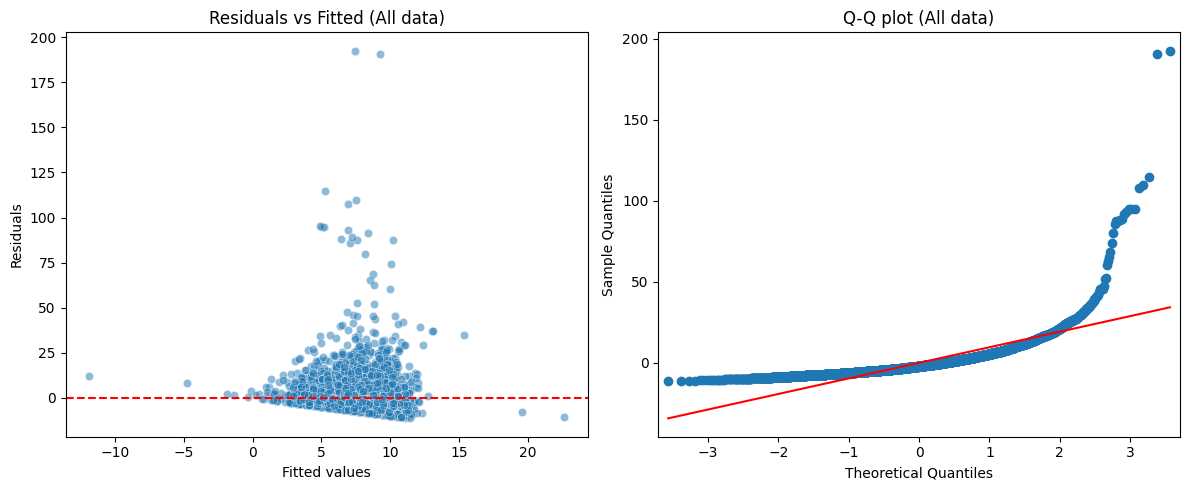

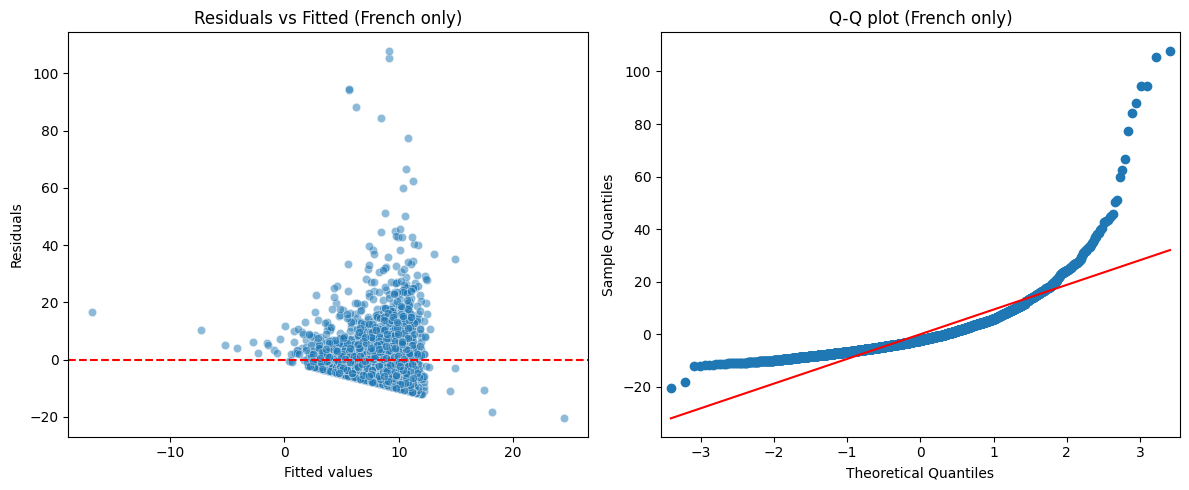

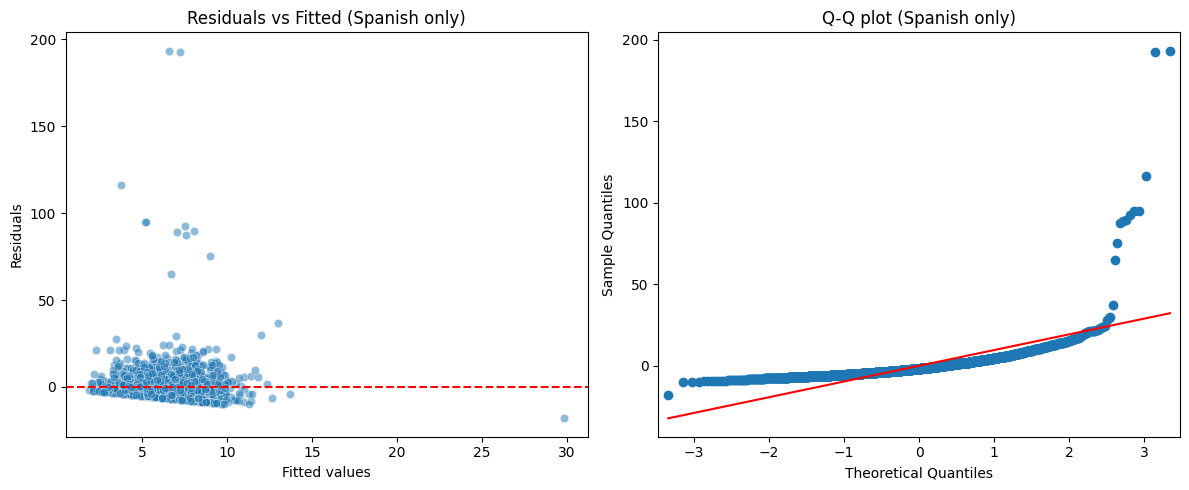

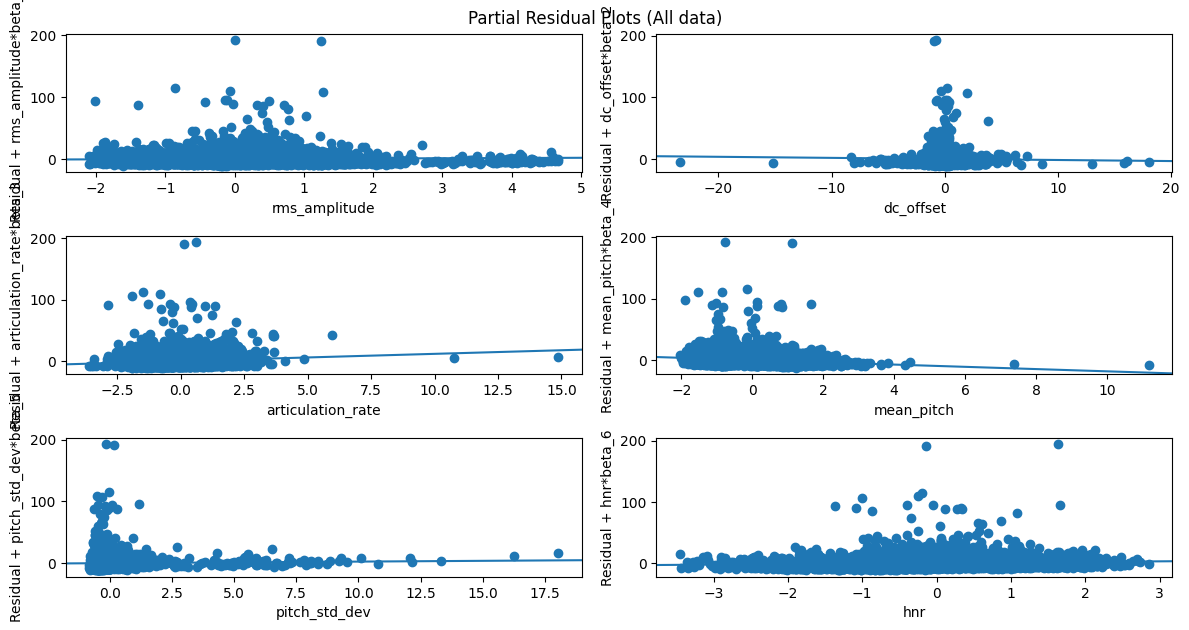

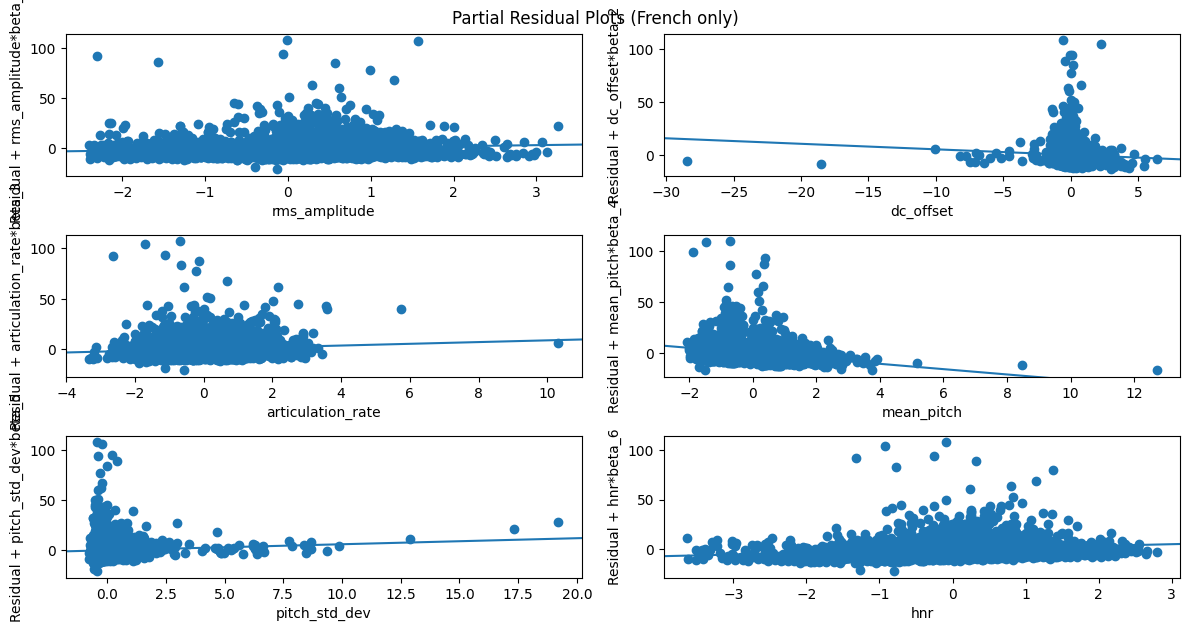

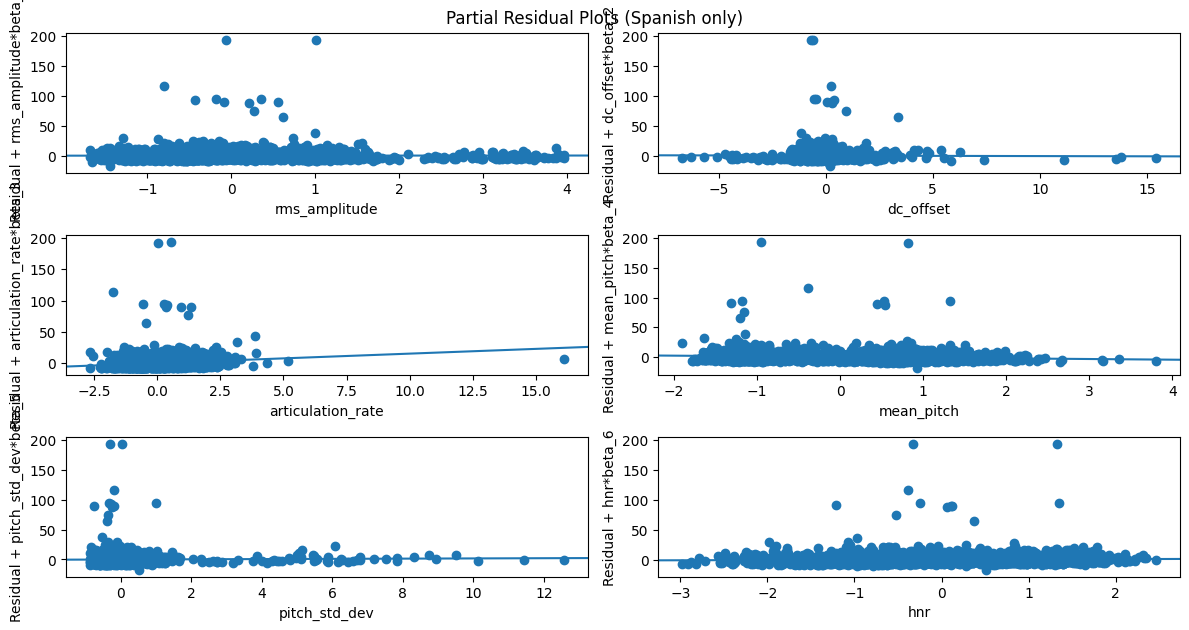

In [8]:
# === Diagnostics: Multicollinearity, Residuals, Partial Residuals ===
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1) Variance Inflation Factors (VIF)
def compute_vif(df, features):
    """Compute VIF for each predictor"""
    X = df[features].dropna().copy()
    X = sm.add_constant(X)  # add intercept
    vifs = pd.Series(
        [variance_inflation_factor(X.values, i) for i in range(X.shape[1])],
        index=X.columns,
        name="VIF"
    )
    return vifs

# Example: pooled dataset
print("\n--- VIF (All data) ---")
print(compute_vif(all_pooled, FEATURES))

print("\n--- VIF (French only) ---")
print(compute_vif(all_pooled.query("language=='french'"), FEATURES))

print("\n--- VIF (Spanish only) ---")
print(compute_vif(all_pooled.query("language=='spanish'"), FEATURES))


# 2) Residuals vs Fitted & Q-Q plots
def plot_residuals(model, label):
    fitted = model.fittedvalues
    residuals = model.resid

    plt.figure(figsize=(12,5))

    # Residuals vs Fitted
    plt.subplot(1,2,1)
    sns.scatterplot(x=fitted, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted ({label})")

    # Q-Q Plot for normality
    plt.subplot(1,2,2)
    sm.qqplot(residuals, line="s", ax=plt.gca())
    plt.title(f"Q-Q plot ({label})")

    plt.tight_layout()
    plt.show()

plot_residuals(ols_all_std, "All data")
plot_residuals(ols_french_std, "French only")
plot_residuals(ols_spanish_std, "Spanish only")


# 3) Partial Residual (Component + Residual) plots
def plot_partial_residuals(model, features, label):
    fig = plt.figure(figsize=(12,8))
    sm.graphics.plot_ccpr_grid(model, fig=fig)  # CCPR = Component+Partial Residual
    fig.suptitle(f"Partial Residual Plots ({label})")
    plt.show()

plot_partial_residuals(ols_all_std, FEATURES, "All data")
plot_partial_residuals(ols_french_std, FEATURES, "French only")
plot_partial_residuals(ols_spanish_std, FEATURES, "Spanish only")


- **VIFs**: none of the features have VIFs>5, making us more comfortable about potential multicollinearity. The constant has a high VIF, likely because the features are centered so will have high correlation with this vector of all 1s.
- **Residual Plots and QQs**: Regression on all data and on french data have "fanning" pattern, where the variance of residuals seems to increase with fitted values --> indicates heteroscedasticity. The results of the spanish-only regression have a less of a pronounced pattern. For all three regressions there is strong departure from the straight line in the upper tail, indicating non-normal residuals with heavy right tails (this is consistent with the fact that WER can spike sometimes >100%). ==> **OLS assumption of normal residuals is violated,  use HC3 (because most conservative) standard errors**
- **Partial Residuals**: Mostly indicates linear-looking relationships, with some fanning (confirms heteroscedasticity)

In [9]:
# === OLS with HC3 robust SEs (standardized predictors, 2 decimal display) ===
import statsmodels.api as sm
import pandas as pd
import numpy as np

def run_ols_hc3_standardized(df, label, features=FEATURES, outcome=OUTCOME):
    df = df.dropna(subset=features + [outcome]).copy()
    # z-score predictors within this subset
    X = df[features]
    X = (X - X.mean()) / X.std(ddof=0)
    X = sm.add_constant(X)
    y = df[outcome]

    model = sm.OLS(y, X).fit(cov_type="HC3")  # <-- robust SEs
    # Build a tidy summary table
    params = model.params.round(2)
    ses    = model.bse.round(2)
    tvals  = model.tvalues.round(2)
    pvals  = model.pvalues.round(2)
    ci     = model.conf_int(alpha=0.05).round(2)

    out = pd.DataFrame({
        "coef": params,
        "robust_se(HC3)": ses,
        "t": tvals,
        "p": pvals,
        "ci_lower": ci[0],
        "ci_upper": ci[1],
    })
    print(f"\n--- OLS (HC3 robust SEs): {label} ---")
    print(f"R^2: {model.rsquared:.3f}   Adj R^2: {model.rsquared_adj:.3f}   N: {int(model.nobs)}")
    display(out)
    return model, out

# Combine pooled data AFTER your 10% holdout filter
all_pooled = pd.concat([d["pooled"] for d in all_results.values()], ignore_index=True)

# Run with HC3 on the three splits
ols_all_hc3,     tab_all_hc3     = run_ols_hc3_standardized(all_pooled, "All data (FR + ES)")
ols_french_hc3,  tab_fr_hc3      = run_ols_hc3_standardized(all_pooled.query("language=='french'"),  "French only")
ols_spanish_hc3, tab_es_hc3      = run_ols_hc3_standardized(all_pooled.query("language=='spanish'"), "Spanish only")



--- OLS (HC3 robust SEs): All data (FR + ES) ---
R^2: 0.036   Adj R^2: 0.035   N: 5483


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,7.20,0.13,55.44,0.00,6.95,7.46
rms_amplitude,0.36,0.11,3.18,0.00,0.14,0.58
dc_offset,-0.17,0.11,-1.50,0.13,-0.40,0.05
articulation_rate,1.17,0.15,7.65,0.00,0.87,1.47
mean_pitch,-1.83,0.17,-10.84,0.00,-2.16,-1.50
pitch_std_dev,0.25,0.11,2.35,0.02,0.04,0.46
hnr,0.89,0.14,6.44,0.00,0.62,1.16



--- OLS (HC3 robust SEs): French only ---
R^2: 0.062   Adj R^2: 0.060   N: 3067


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,8.03,0.17,47.18,0.0,7.69,8.36
rms_amplitude,1.07,0.17,6.44,0.0,0.75,1.40
dc_offset,-0.52,0.32,-1.63,0.1,-1.14,0.10
articulation_rate,0.86,0.22,3.90,0.0,0.43,1.29
mean_pitch,-2.60,0.25,-10.61,0.0,-3.09,-2.12
pitch_std_dev,0.60,0.18,3.37,0.0,0.25,0.95
hnr,1.73,0.20,8.53,0.0,1.33,2.13



--- OLS (HC3 robust SEs): Spanish only ---
R^2: 0.030   Adj R^2: 0.027   N: 2416


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,6.16,0.20,31.29,0.00,5.77,6.54
rms_amplitude,0.04,0.16,0.22,0.82,-0.28,0.35
dc_offset,-0.07,0.16,-0.45,0.65,-0.39,0.25
articulation_rate,1.52,0.24,6.23,0.00,1.04,2.00
mean_pitch,-1.13,0.23,-4.92,0.00,-1.58,-0.68
pitch_std_dev,0.18,0.16,1.15,0.25,-0.13,0.48
hnr,0.38,0.20,1.95,0.05,-0.00,0.77


- Key drivers remain the same, with the only difference that french dc offset became outside of the p<0.05 threshold
- Won't be dropping the (very few) insignificant variables as collinearity wasn't much of a problem here

## Rerunning the HC3 regressions with log(1+WER) as the outcome to try to deal with the right tail outliers


--- OLS (HC3 robust SEs): All data (FR + ES) | Outcome = log1p(WER) ---
R^2: 0.052   Adj R^2: 0.051   N: 5483


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,1.64,0.01,123.83,0.00,1.61,1.66
rms_amplitude,0.04,0.01,2.83,0.00,0.01,0.07
dc_offset,-0.04,0.01,-2.59,0.01,-0.07,-0.01
articulation_rate,0.17,0.01,11.96,0.00,0.14,0.19
mean_pitch,-0.19,0.02,-10.37,0.00,-0.23,-0.16
pitch_std_dev,0.02,0.01,1.34,0.18,-0.01,0.05
hnr,0.08,0.02,5.11,0.00,0.05,0.12


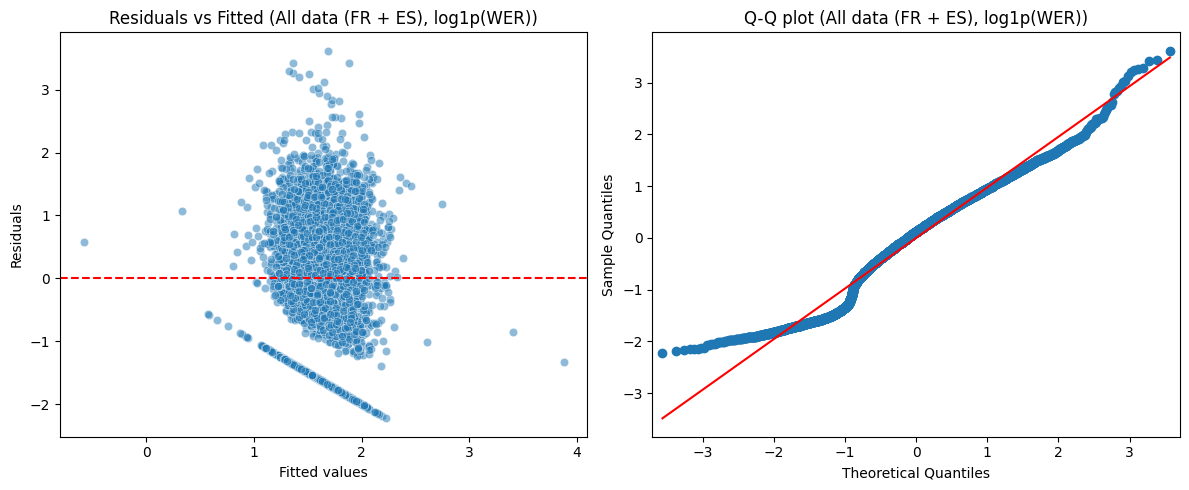


--- OLS (HC3 robust SEs): French only | Outcome = log1p(WER) ---
R^2: 0.079   Adj R^2: 0.077   N: 3067


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,1.75,0.02,100.44,0.00,1.71,1.78
rms_amplitude,0.13,0.02,7.31,0.00,0.10,0.17
dc_offset,-0.08,0.04,-1.93,0.05,-0.17,0.00
articulation_rate,0.13,0.02,6.84,0.00,0.09,0.16
mean_pitch,-0.25,0.03,-9.35,0.00,-0.30,-0.20
pitch_std_dev,0.05,0.02,2.19,0.03,0.01,0.09
hnr,0.17,0.02,7.15,0.00,0.12,0.21


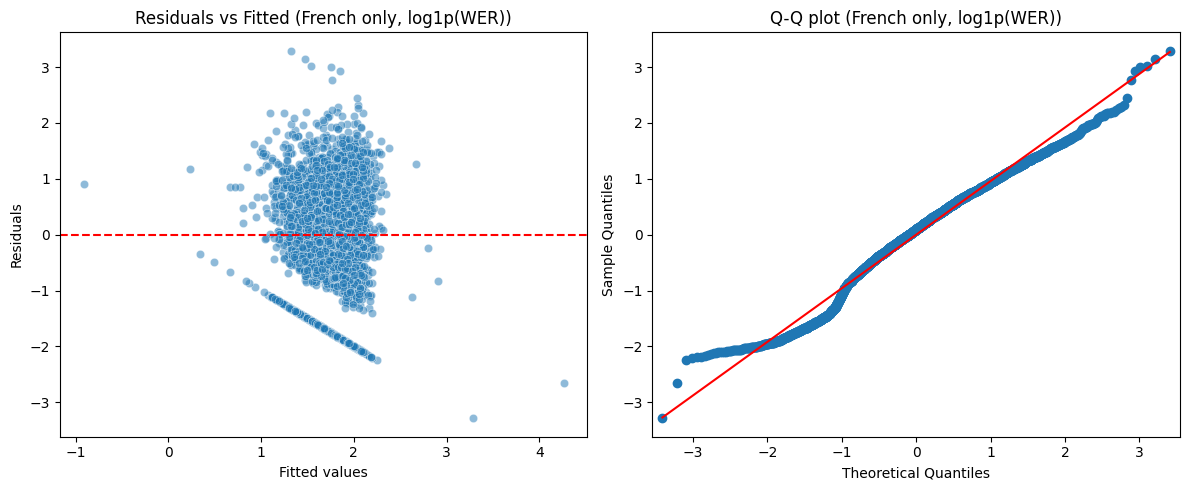


--- OLS (HC3 robust SEs): Spanish only | Outcome = log1p(WER) ---
R^2: 0.055   Adj R^2: 0.052   N: 2416


,coef,robust_se(HC3),t,p,ci_lower,ci_upper
const,1.50,0.02,76.04,0.00,1.46,1.54
rms_amplitude,-0.01,0.02,-0.48,0.63,-0.05,0.03
dc_offset,-0.02,0.02,-1.24,0.21,-0.06,0.01
articulation_rate,0.21,0.03,8.15,0.00,0.16,0.26
mean_pitch,-0.14,0.03,-5.52,0.00,-0.19,-0.09
pitch_std_dev,0.02,0.02,0.96,0.34,-0.02,0.06
hnr,0.04,0.02,1.70,0.09,-0.01,0.08


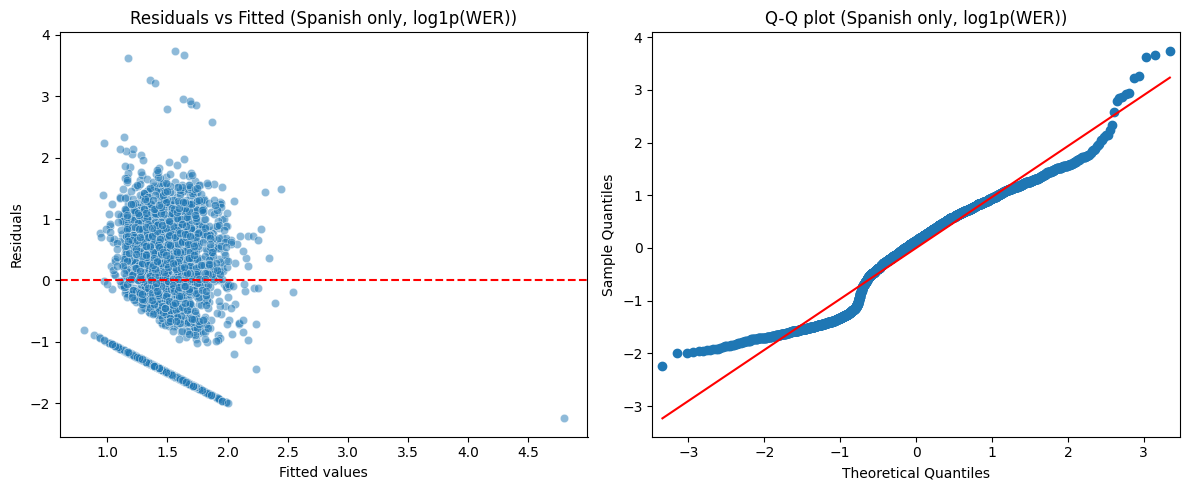

In [10]:
# === OLS with HC3 robust SEs, outcome = log1p(WER) ===
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def run_ols_hc3_logwer(df, label, features=FEATURES, outcome=OUTCOME):
    df = df.dropna(subset=features + [outcome]).copy()
    # log-transform outcome
    df["log1p_wer"] = np.log1p(df[outcome])
    # z-score predictors within this subset
    X = df[features]
    X = (X - X.mean()) / X.std(ddof=0)
    X = sm.add_constant(X)
    y = df["log1p_wer"]

    model = sm.OLS(y, X).fit(cov_type="HC3")  # robust SEs
    # Build a tidy summary table
    params = model.params.round(2)
    ses    = model.bse.round(2)
    tvals  = model.tvalues.round(2)
    pvals  = model.pvalues.round(2)
    ci     = model.conf_int(alpha=0.05).round(2)

    out = pd.DataFrame({
        "coef": params,
        "robust_se(HC3)": ses,
        "t": tvals,
        "p": pvals,
        "ci_lower": ci[0],
        "ci_upper": ci[1],
    })
    print(f"\n--- OLS (HC3 robust SEs): {label} | Outcome = log1p(WER) ---")
    print(f"R^2: {model.rsquared:.3f}   Adj R^2: {model.rsquared_adj:.3f}   N: {int(model.nobs)}")
    display(out)

    # Residual diagnostics
    fitted = model.fittedvalues
    residuals = model.resid

    plt.figure(figsize=(12,5))
    # Residuals vs Fitted
    plt.subplot(1,2,1)
    sns.scatterplot(x=fitted, y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Fitted values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Fitted ({label}, log1p(WER))")

    # Q-Q Plot
    plt.subplot(1,2,2)
    sm.qqplot(residuals, line="s", ax=plt.gca())
    plt.title(f"Q-Q plot ({label}, log1p(WER))")

    plt.tight_layout()
    plt.show()

    return model, out

# Pooled dataset after your 10% holdout split
all_pooled = pd.concat([d["pooled"] for d in all_results.values()], ignore_index=True)

# Run three regressions with log1p(WER)
ols_all_log, tab_all_log       = run_ols_hc3_logwer(all_pooled, "All data (FR + ES)")
ols_french_log, tab_fr_log     = run_ols_hc3_logwer(all_pooled.query("language=='french'"), "French only")
ols_spanish_log, tab_es_log    = run_ols_hc3_logwer(all_pooled.query("language=='spanish'"), "Spanish only")


- The r^2 slightly increased, especially for french & spanish
- QQ plots look much better, closer to the linear line
- Residual plots have lost their fanning pattern, generally look better except for the diagonal band --> this is caused by the cases where WER = 0, since log1p(0)=0, all those points collapse to the same transformed outcome, so the regression systematically over or under predicts them. To handle this, could try a **two-part model / hurdle model**.
- Coefficients: only negative ones are mean pitch and dc offset, like in previous iterations
- P-values: only insignificant variables: spanish hnr, pitch std dev, rms amplitude / french dc offset / overall none
    **strongest still seem to be articulation rate, mean pitch**

## Delta Regression

For every line ID that exists in both original and transformed dataset, computes: 
- WER transformed - WER original
- log (1+ WER transformed) - log (1+ WER original)
- for each feature: transformed feature - original feature
- so each row in the regression is one line, each predictor is changes in features caused by the Cartesia transform

In [11]:
# === Δ-Regression (primary inference) ===
from sklearn.pipeline import Pipeline

results_delta = {}
for language, d in all_results.items():
    lp = d["line_paired"].copy()
    if lp.empty:
        print(f"{language}: no line-paired data; skipping Δ-regression.")
        continue
    
    # Standardize Δ features within language
    dcols = [f"d_{c}" for c in FEATURES]
    # Replace any inf/nan
    lp = lp.replace([np.inf,-np.inf], np.nan).dropna(subset=dcols+["d_log1p_wer","speaker_id"])
    
    X = lp[dcols].values
    y = lp["d_log1p_wer"].values
    speakers = lp["speaker_id"].astype(str).values
    
    # Ridge CV with GroupKFold by speaker for λ selection
    gkf = GroupKFold(n_splits=min(5, len(np.unique(speakers))))
    alphas = np.logspace(-3, 3, 25)
    ridge = RidgeCV(alphas=alphas, cv=gkf)
    ridge.fit(X, y, groups=speakers)
    
    # Selected alpha and coefficients
    coefs = pd.Series(ridge.coef_, index=dcols, name="ridge_coef")
    
    # Refit OLS for interpretable β + clustered SEs (by speaker)
    df_model = lp[dcols + ["d_log1p_wer","speaker_id"]].copy()
    formula = "d_log1p_wer ~ " + " + ".join(dcols)
    ols_fit = ols(formula, data=df_model).fit(cov_type="cluster", cov_kwds={"groups": df_model["speaker_id"]})
    summ = pd.DataFrame({
        "beta_ols": ols_fit.params.reindex(["Intercept"]+dcols, fill_value=np.nan),
        "se_clustered": ols_fit.bse.reindex(["Intercept"]+dcols, fill_value=np.nan),
        "pval": ols_fit.pvalues.reindex(["Intercept"]+dcols, fill_value=np.nan)
    })
    # FDR on feature p-values
    mask = summ.index.isin(dcols)
    rej, pcor = bh_fdr(summ.loc[mask,"pval"].values, alpha=0.05)
    summ.loc[mask,"pval_fdr"] = pcor
    summ.loc[mask,"significant_fdr"] = rej
    
    results_delta[language] = {
        "ridge_alpha": ridge.alpha_,
        "ridge_coefs": coefs,
        "ols_summary": summ,
        "ols_model": ols_fit
    }
    print(f"\\n[{language.upper()}] Δ-Regression done. Selected ridge alpha = {ridge.alpha_:.4g}")
    display(summ)


ValueError: Passing extra keyword arguments to RidgeCV.fit is only supported if enable_metadata_routing=True, which you can set using `sklearn.set_config`. See the User Guide <https://scikit-learn.org/stable/metadata_routing.html> for more details. Extra parameters passed are: {'groups'}

## Chi squared tests

In [ ]:
# === Chi-square tests ===
from scipy.stats import chi2_contingency, binomtest

def chisq_improvement(language, d):
    lp = d["line_paired"]
    if lp.empty:
        return None
    tbl = pd.crosstab(index=[language], columns=(lp["d_wer"]<0).map({True:"Improved", False:"Worsened"}))
    return tbl

# 1) Overall improved vs worsened per language + binomial test
all_tbls = []
for language, d in all_results.items():
    lp = d["line_paired"]
    if lp.empty:
        print(f"{language}: no line-paired data, skipping chi-square.")
        continue
    improved = int((lp["d_wer"]<0).sum())
    worsened = int((lp["d_wer"]>=0).sum())
    n = improved + worsened
    print(f"\\n[{language.upper()}] Improved={improved}, Worsened={worsened}")
    # Binomial test vs 50/50
    bt = binomtest(improved, n, p=0.5, alternative="two-sided")
    print(f"Binomial test p-value (improvement rate ≠ 50%): {bt.pvalue:.4g}")
    all_tbls.append(pd.DataFrame({"Improved":[improved],"Worsened":[worsened]}, index=[language]))
    
# 2) Chi-square comparing improvement rates across languages
if len(all_tbls)>=2:
    combo = pd.concat(all_tbls)
    chi2, p, dof, exp = chi2_contingency(combo.values, correction=False)
    print("\\n[FR vs ES] Chi-square on improvement rates")
    print(combo)
    print(f"Chi2={chi2:.3f}, dof={dof}, p={p:.4g}")

# 3) Improvement vs feature-change quartiles (per language, top features by |ridge_coef|)
for language, d in all_results.items():
    lp = d["line_paired"]
    if lp.empty:
        continue
    print(f"\\n[{language.upper()}] Chi-square: Improvement vs Δ-feature quartiles")
    # pick top 3 by absolute ridge coef (from delta results if available)
    dcols = [f"d_{c}" for c in FEATURES]
    if language in results_delta:
        top = results_delta[language]["ridge_coefs"].reindex(dcols).abs().sort_values(ascending=False).head(3).index.tolist()
    else:
        top = dcols[:3]
    for col in top:
        try:
            q = pd.qcut(lp[col], 4, labels=["Q1","Q2","Q3","Q4"])
            tbl = pd.crosstab(q, (lp["d_wer"]<0).map({True:"Improved",False:"Worsened"}))
            chi2, p, dof, exp = chi2_contingency(tbl.values, correction=False)
            print(f" - {col}: Chi2={chi2:.3f}, dof={dof}, p={p:.4g}")
        except Exception as e:
            print(f" - {col}: skipped ({e})")


## Mixed effects confirmation

In [ ]:
# === Mixed-effects confirmation on pooled long set ===
mixed_results = {}
for language, d in all_results.items():
    pooled = d["pooled"].copy()
    if pooled.empty:
        continue
    # Standardize features within language (pooled)
    for c in FEATURES:
        pooled[f"{c}_z"] = (pooled[c] - pooled[c].mean()) / (pooled[c].std(ddof=0) + 1e-9)
    # Build fixed effects: treatment + features + interactions (limited to top 3 to keep model stable)
    # We'll pick top 3 Δ features from delta ridge for interactions guidance, otherwise first 3.
    if language in results_delta:
        top_base = [c.replace("d_","") for c in results_delta[language]["ridge_coefs"].abs().sort_values(ascending=False).head(3).index.tolist()]
    else:
        top_base = FEATURES[:3]
    fixed_cols = ["treatment"] + [f"{c}_z" for c in FEATURES] + [f"treatment:{c}_z" for c in top_base]
    
    # Design matrices
    exog = pd.DataFrame({"Intercept":1.0}, index=pooled.index)
    for c in FEATURES:
        exog[f"{c}_z"] = pooled[f"{c}_z"]
    exog["treatment"] = pooled["treatment"].astype(int)
    for c in top_base:
        exog[f"treatment:{c}_z"] = exog["treatment"] * exog[f"{c}_z"]
    endog = pooled["log1p_wer"]
    
    # Random intercepts: speaker, country, gender (use combined groups to approximate multiple REs)
    # statsmodels MixedLM accepts one grouping var; we fit with speaker_id, then as a robustness fit with country-gender.
    for grouping in ["speaker_id", None]:
        if grouping is None:
            pooled["cg"] = pooled["country"].astype(str) + "|" + pooled["gender"].astype(str)
            grouping = "cg"
        try:
            md = MixedLM(endog, exog, groups=pooled[grouping].astype(str))
            mdf = md.fit(method="lbfgs", reml=True, maxiter=200, disp=False)
            mixed_results[(language, grouping)] = mdf
            print(f"[{language.upper()}] MixedLM fit with groups={grouping}: converged, AIC={mdf.aic:.1f}")
        except Exception as e:
            print(f"[{language.upper()}] MixedLM failed with groups={grouping}: {e}")


In [ ]:
# === Simple mediation estimate (proportion explained) ===
# We estimate how much of the treatment effect (theta) is explained by feature shifts.
# Approach: compare two pooled OLS models — with and without features — and compute the
# change in the estimated treatment coefficient. Bootstrap by speaker for CI.
from tqdm.auto import tqdm

def treatment_coef(pooled, with_features=True, top_feats=None):
    df = pooled.copy()
    df["log1p_wer"] = np.log1p(df[OUTCOME])
    if with_features:
        Xcols = ["treatment"] + top_feats
    else:
        Xcols = ["treatment"]
    X = sm.add_constant(df[Xcols])
    y = df["log1p_wer"]
    model = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": df["speaker_id"].astype(str)})
    return model.params.get("treatment", np.nan)

def bootstrap_prop_mediated(pooled, B=200, top_feats=None):
    speakers = pooled["speaker_id"].astype(str).unique()
    pm = []
    for b in range(B):
        samp = np.random.choice(speakers, size=len(speakers), replace=True)
        dfb = pd.concat([pooled[pooled["speaker_id"].astype(str)==s] for s in samp], ignore_index=True)
        theta0 = treatment_coef(dfb, with_features=False, top_feats=top_feats)
        theta1 = treatment_coef(dfb, with_features=True, top_feats=top_feats)
        pm.append(1 - (theta1/theta0) if theta0!=0 else np.nan)
    pm = pd.Series(pm).dropna()
    return pm.mean(), pm.quantile([0.025, 0.975]).values

for language, d in all_results.items():
    pooled = d["pooled"].copy()
    if pooled.empty:
        continue
    # choose top features by |ridge| on deltas (fallback to all z-features if not available)
    if language in results_delta:
        top = [c.replace("d_","") for c in results_delta[language]["ridge_coefs"].abs().sort_values(ascending=False).head(4).index.tolist()]
    else:
        top = FEATURES
    top_z = [f"{c}_z" for c in top]
    # create z features
    for c in FEATURES:
        pooled[f"{c}_z"] = (pooled[c] - pooled[c].mean()) / (pooled[c].std(ddof=0) + 1e-9)
    try:
        mean_pm, (lo, hi) = bootstrap_prop_mediated(pooled, B=200, top_feats=top_z)
        print(f"[{language.upper()}] Estimated proportion of treatment effect mediated by features: {mean_pm:.2%} (95% CI {lo:.2%}–{hi:.2%})")
    except Exception as e:
        print(f"[{language.upper()}] Mediation bootstrap failed: {e}")


In [ ]:
# === Quick plots (optional) ===
for language, d in all_results.items():
    lp = d["line_paired"]
    if lp.empty:
        continue
    plt.figure()
    plt.hist(lp["d_wer"].dropna(), bins=40)
    plt.title(f"{language.capitalize()}: ΔWER histogram")
    plt.xlabel("ΔWER (transformed - original)")
    plt.ylabel("Count")
    plt.show()


---

## Next steps you may customize
- If you want stricter causal language, keep analysis descriptive + mediation as *attribution* (not identification).
- Consider exporting tables (coefficients, chi‑square results) to CSV for your report.
